In [1]:
import tensorflow as tf 
from tensorflow import keras    
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import read_signal as rs
import tqdm
from matplotlib.animation import FuncAnimation 
# ! pip install tensorflow_addons
import tensorflow_addons as tfa

2024-02-03 23:57:06.686303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 23:57:06.689815: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 23:57:06.731846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 23:57:06.731870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 23:57:06.732909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Extracting EDF parameters from /home/nima/BraiNeoCare/Datasets/zenodo_eeg/eeg19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[ 312 1273 1871 2399 2681 2912 3006 4738 8807] [ 366 1319 1932 2546 2783 2975 3680 5634 8853]


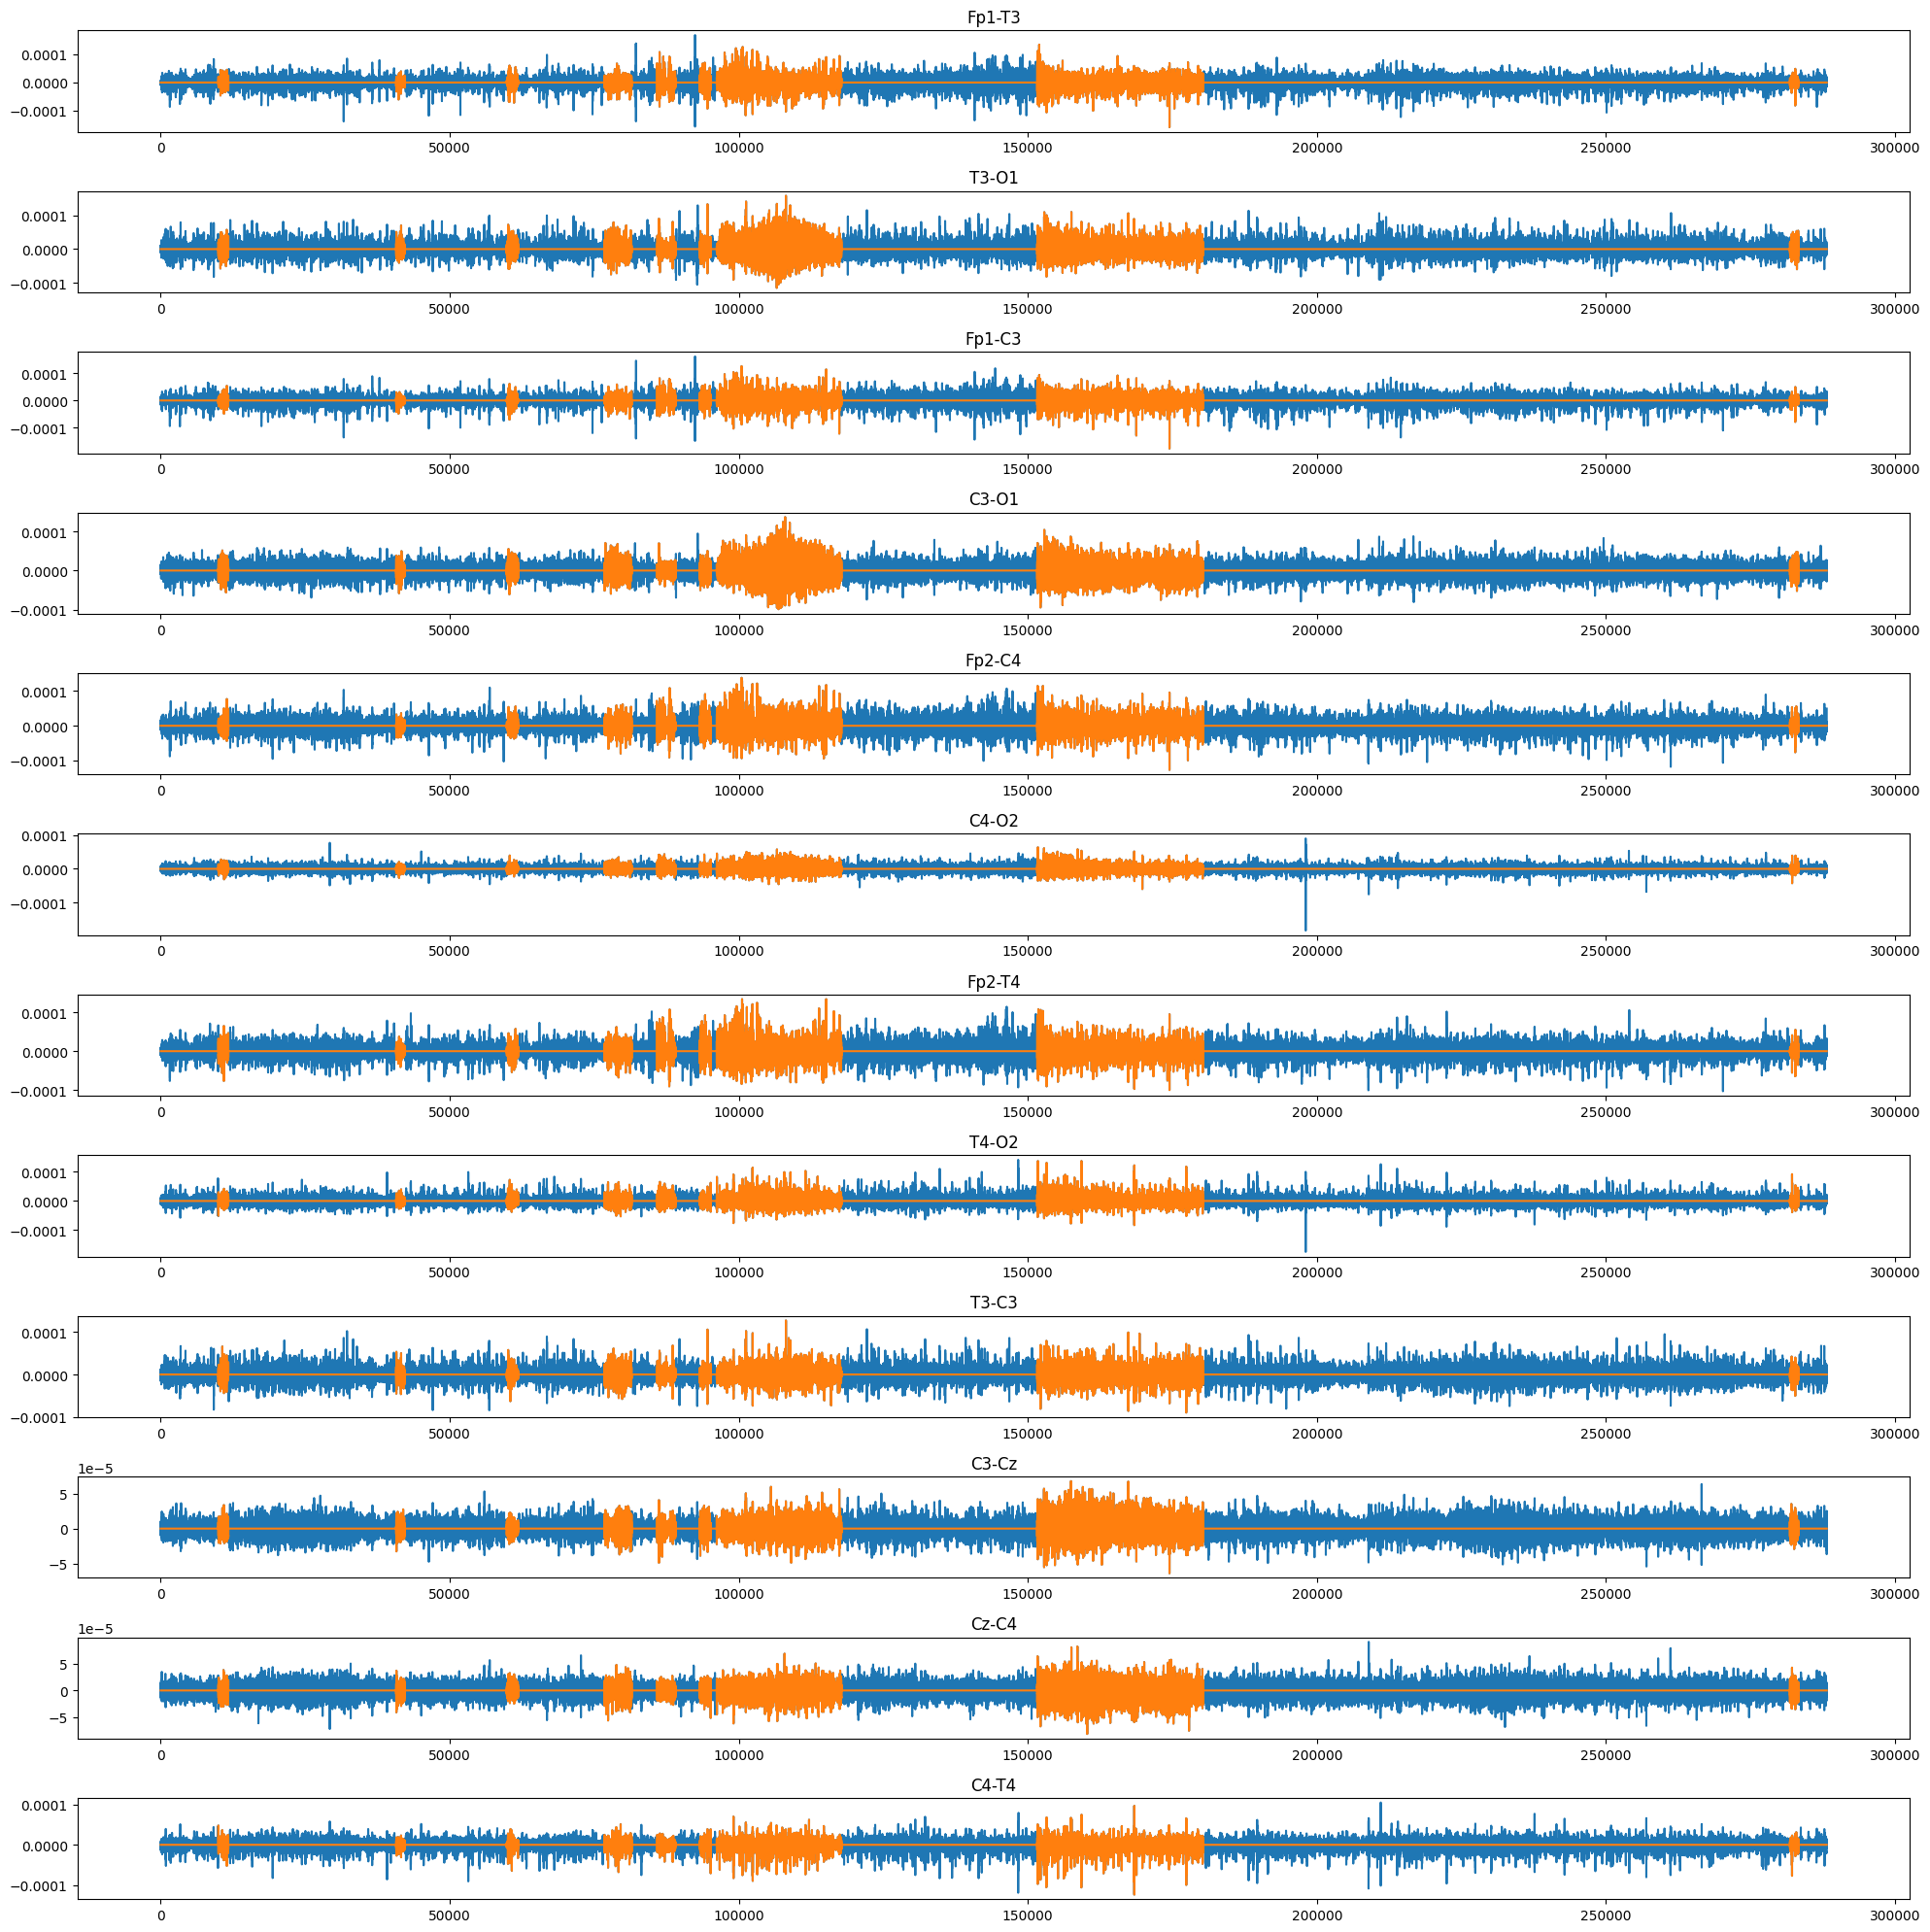

In [36]:
EEG,labels=rs.read_file("../BraiNeoCare/Datasets/zenodo_eeg/eeg19.edf",19)

In [3]:
model = keras.models.load_model("Saved_models/GAT_model_correct_4/cp_0053.ckpt")
model.layers[-1].activation = None

2024-02-03 23:59:41.689498: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
grad_model = keras.Model(model.inputs,[model.get_layer("gat_layer_11").output,model.output])

def PreprocesSignal(signal,mean,std):
    signal=(signal-mean)/std
    signal=np.expand_dims(signal,axis=-1)
    signal=np.expand_dims(signal,axis=0)
    return signal

def GradCAM(signal,model=grad_model):
    
    with tf.GradientTape() as tape:
        CNN_outputs, predictions = grad_model(signal)
        Class=predictions[:,0]

    grads = tape.gradient(Class, CNN_outputs)

    heatmap = CNN_outputs[0] * tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.nn.relu(heatmap)/tf.reduce_max(heatmap)
    # print(tf.reduce_mean(grads, axis=(0,1,2)))
    return heatmap.numpy(),tf.nn.sigmoid(predictions[0][0]).numpy()

In [5]:
x_train=np.load('./Datasets/GAT/traindata.npy')

In [6]:
mean=x_train.mean()
std=x_train.std()    

In [31]:
2036*32

65152

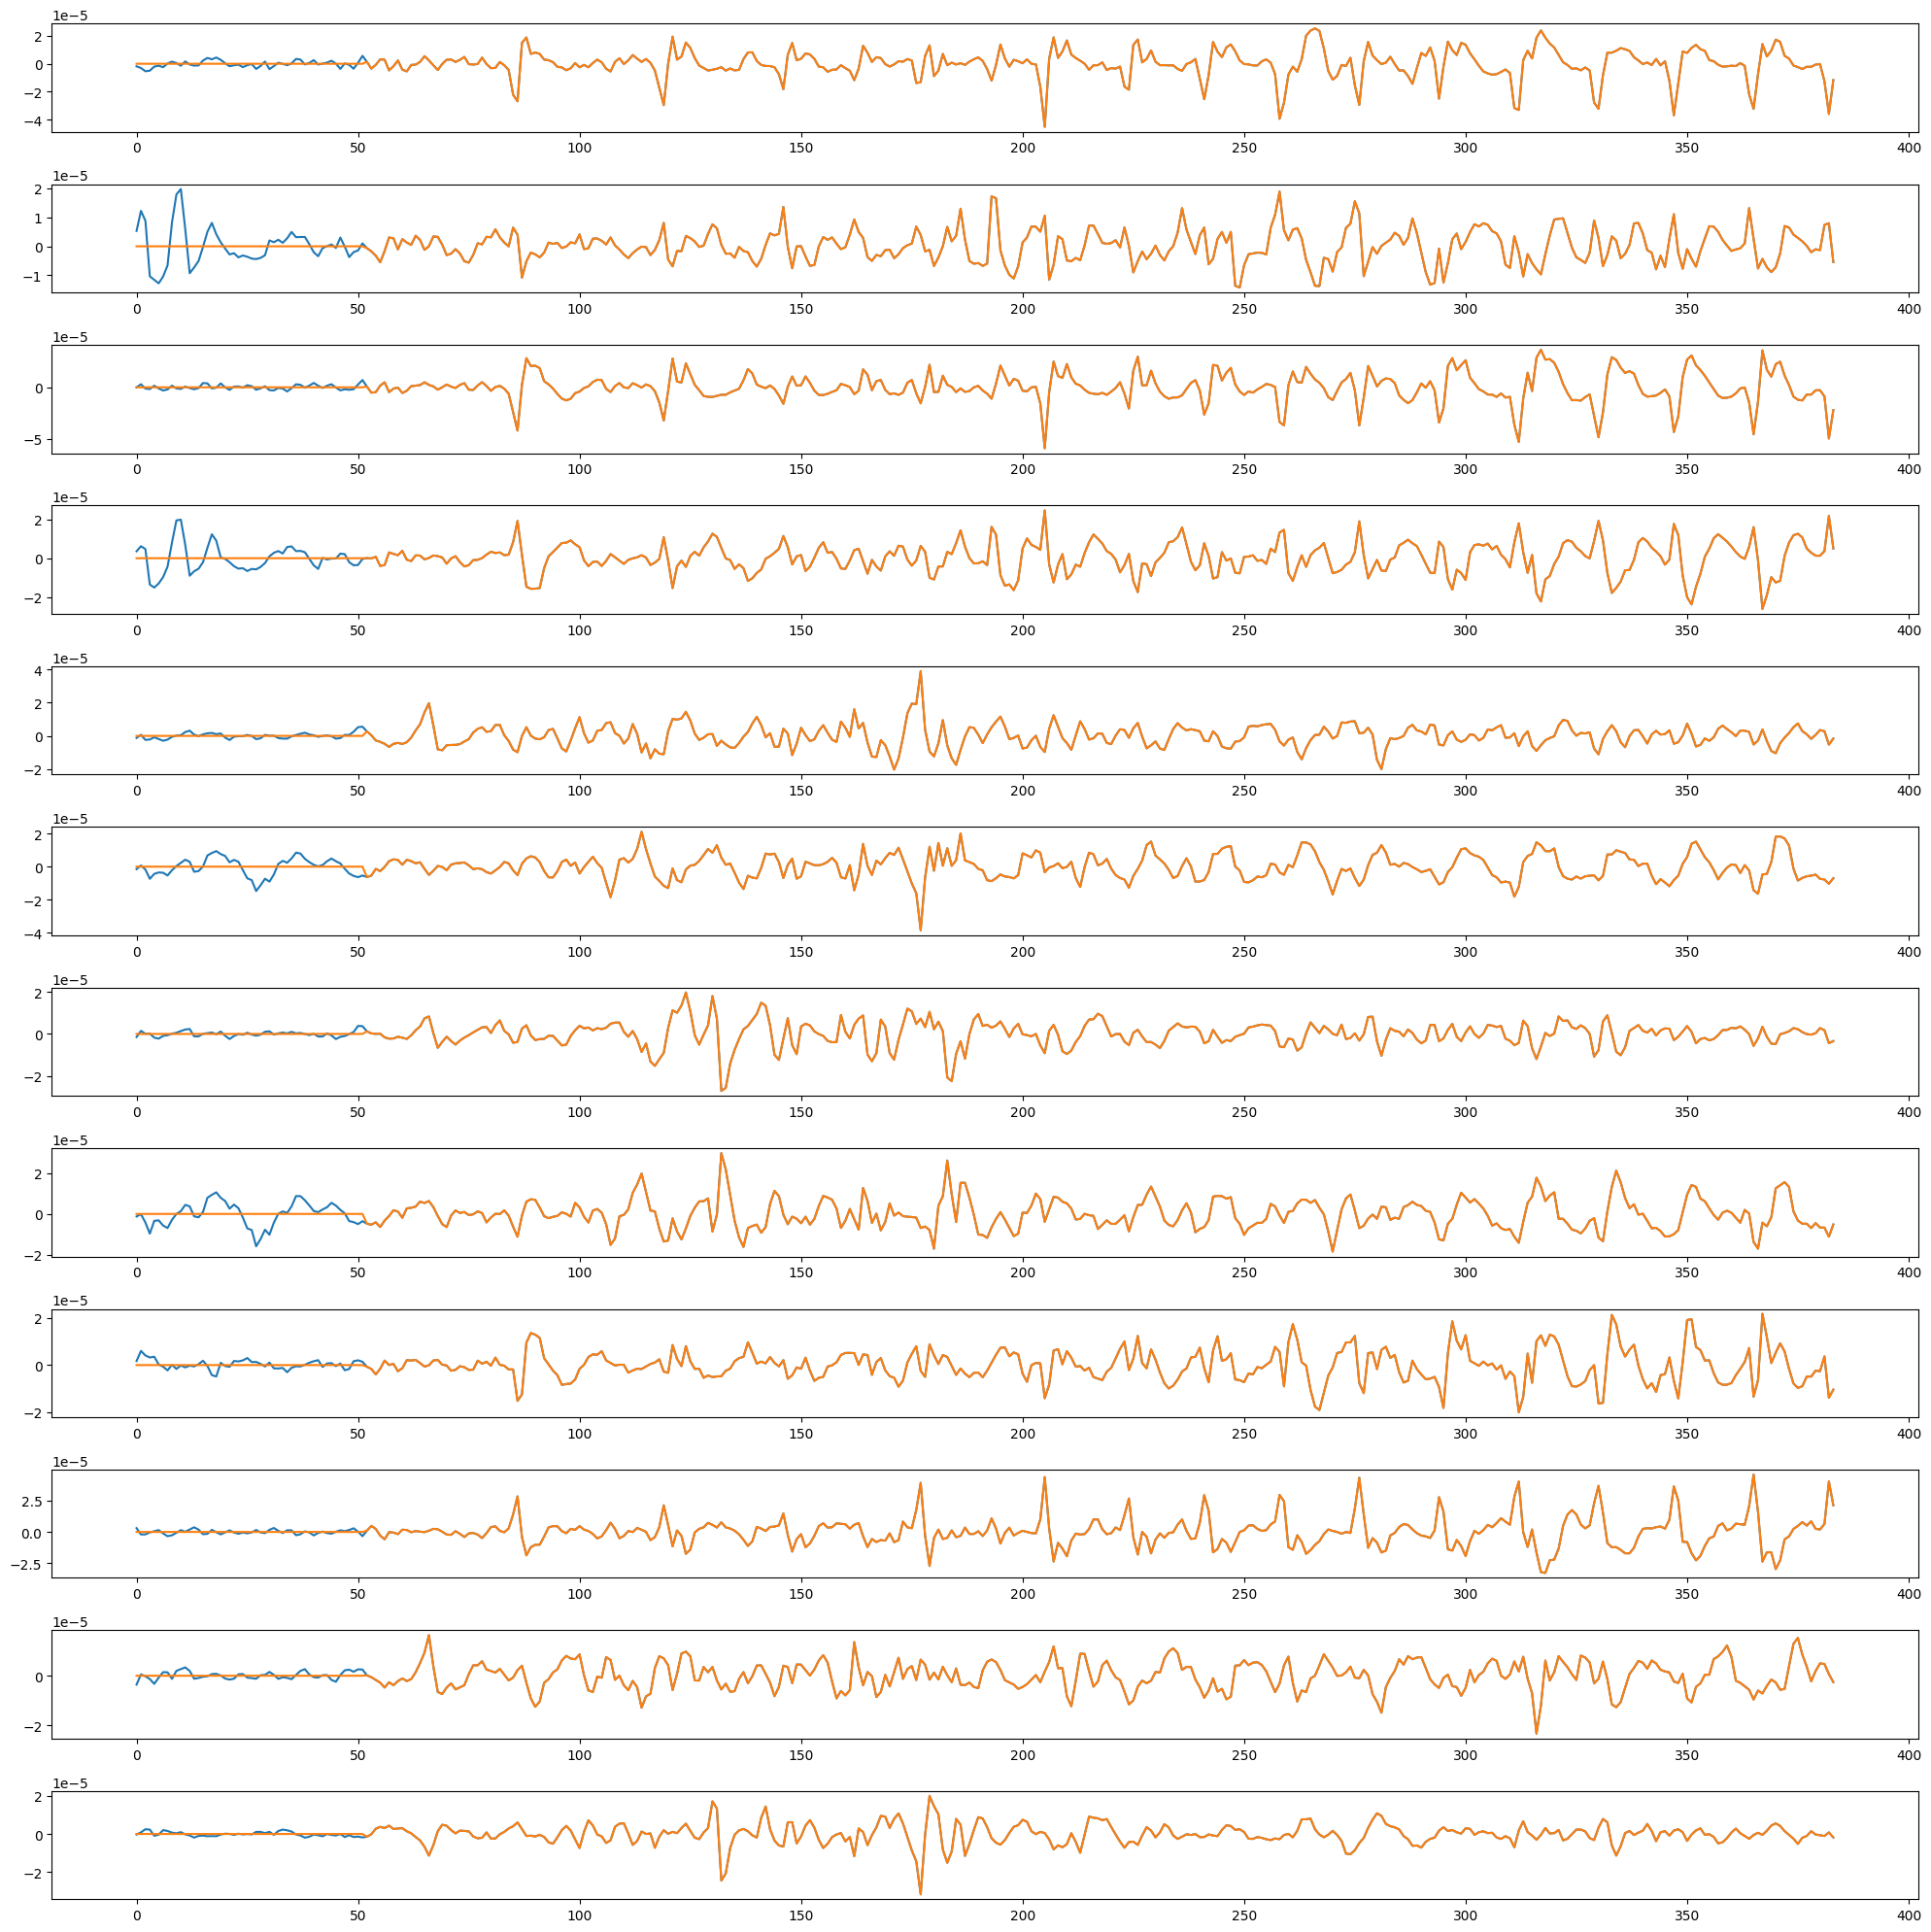

In [35]:
fig,ax=plt.subplots(12,1,figsize=(20,20))
lb=65100
ub=65100+384
for r in range(12):
    ax[r].plot(EEG[r][lb:ub])
    ax[r].plot(labels[r][lb:ub])
    # ax[r].set_title(channel_names[r])
fig.tight_layout()
plt.show()

prediction:-  1


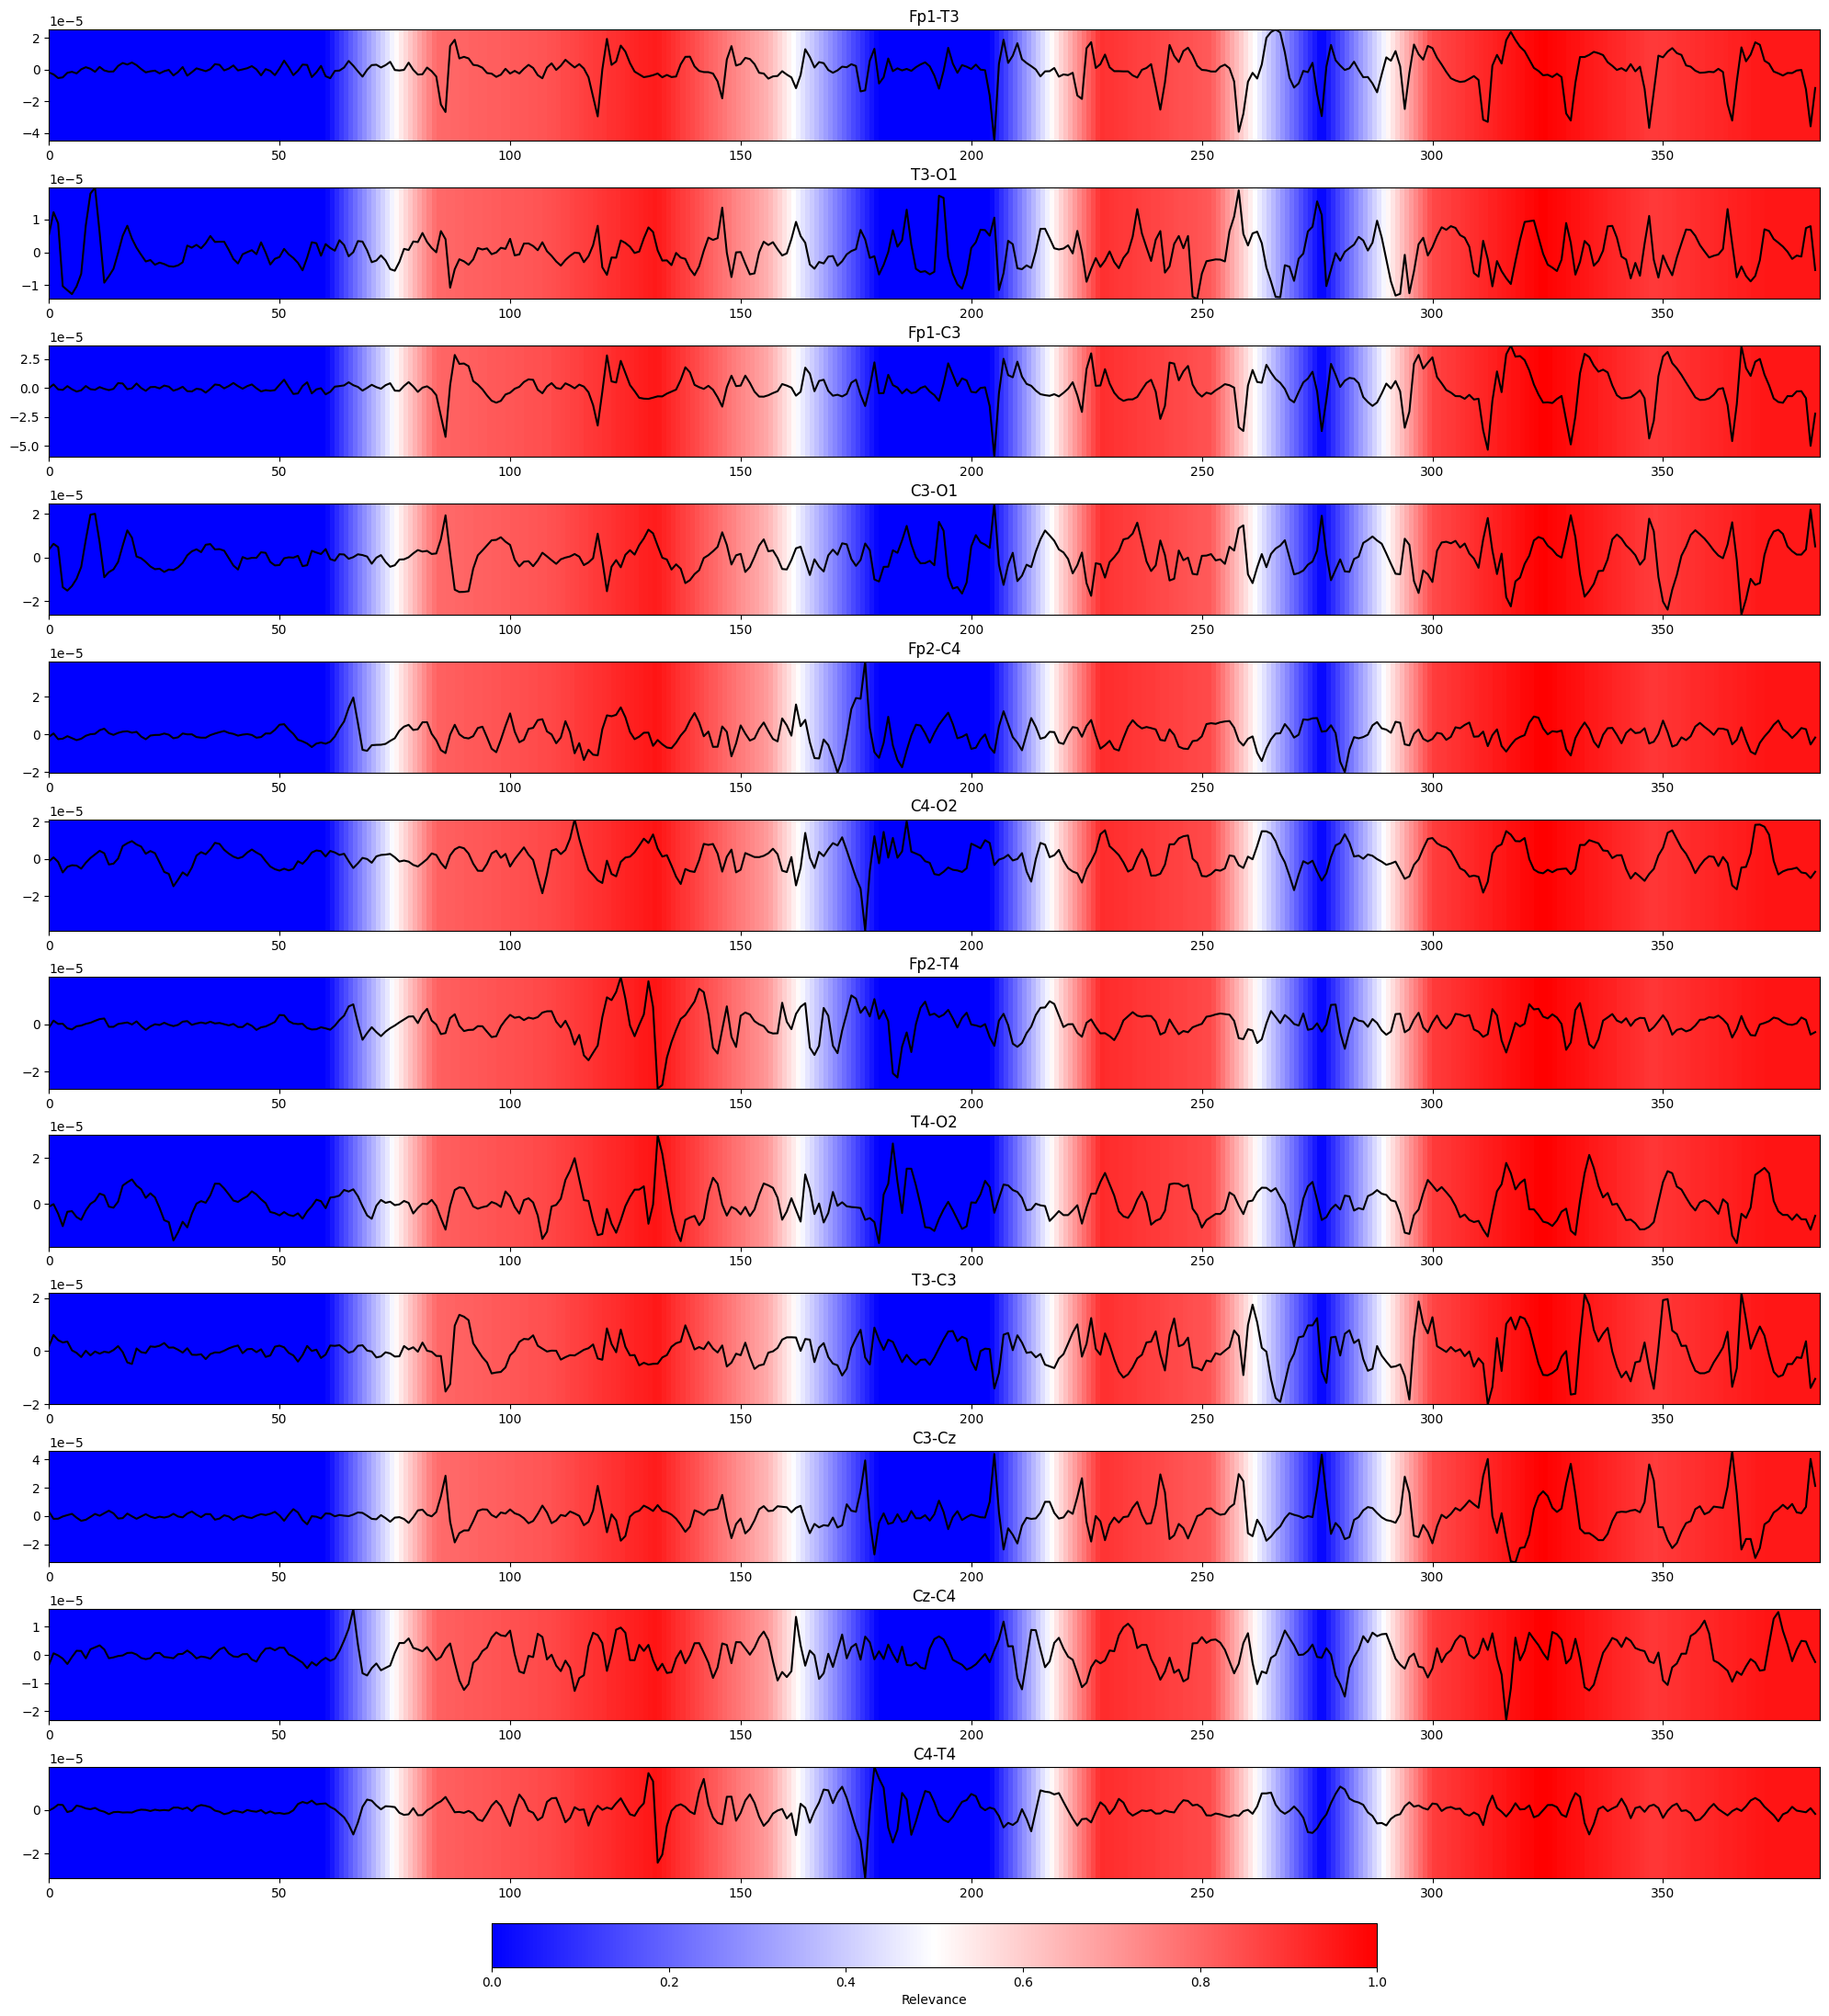

In [34]:
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
n=3
lb=65100
ub=65100+384
x=PreprocesSignal(EEG[:,lb:ub],mean,std)
h,p=GradCAM(x)
print("prediction:- ",1 if p>=0.5 else 0)
# print(h)
resized_heatmap = cv.resize(h, (384,12), interpolation=cv.INTER_LINEAR)
fig,ax=plt.subplots(12,1,figsize=(20,25))
for r in range(12):
    ax[r].plot(EEG[r,lb:ub],color='k')
    im=ax[r].imshow(resized_heatmap[r].reshape(1,384),cmap='bwr',alpha=1,extent=[0,384,EEG[r,lb:ub].min(),EEG[r,lb:ub].max()],aspect='auto',vmax=1,vmin=0)
    ax[r].set_title(channel_names[r])   
fig.tight_layout()
cbar=fig.colorbar(im,ax=ax,orientation='horizontal',pad=0.02,shrink=0.5)
cbar.set_label('Relevance')
plt.show()